In [1]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim

In [16]:
A0 = 10**(106/20)
wp = 2*np.pi*5
A = lambda s: A0/(1+s/wp)

In [13]:
data_10 = pd.read_csv("1_bode_1k_10k_retake.csv", names=["f", "mag", "phase"], skiprows=1)
data_10["phase"] += 360
data_100 = pd.read_csv("1_bode_1k_100k.csv", names=["f", "mag", "phase"], skiprows=1)

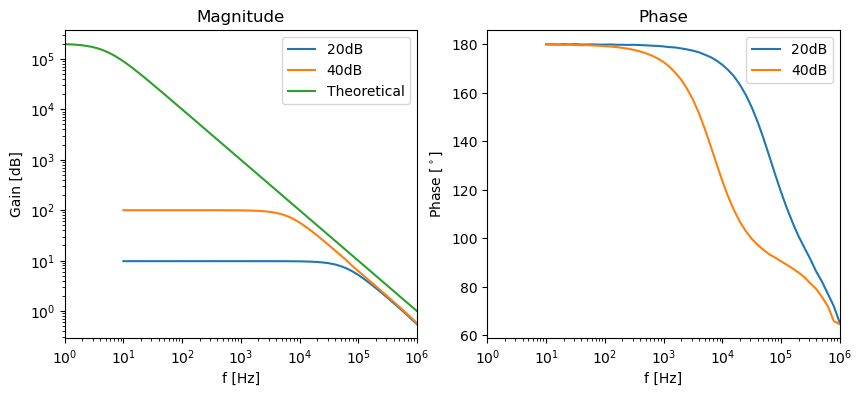

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axstg = AxesSetting(title="Magnitude", xlabel="f [Hz]", ylabel="Gain [dB]", xscale="log", yscale="log", xlim=(1, 1e6))
axes[0].plot(data_10["f"], data_10["mag"], label="20dB")
axes[0].plot(data_100["f"], data_100["mag"], label="40dB")
axstg.plot_func(axes[0], lambda f: np.abs(A(2j*np.pi*f)), label="Theoretical")
axstg.apply_axes(axes[0])
axstg = AxesSetting(title="Phase", xlabel="f [Hz]", ylabel="Phase [$^\circ$]", xscale="log", yscale="linear", xlim=(1, 1e6))
axes[1].plot(data_10["f"], data_10["phase"], label="20dB")
axes[1].plot(data_100["f"], data_100["phase"], label="40dB")
# axstg.plot_func(axes[1], lambda f: np.angle(A(2j*np.pi*f), deg=True), label="Theoretical")
axstg.apply_axes(axes[1])